In [4]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd

# Configuration
SESSION_ID = "2024-2025"
BASE_URL = "https://data.stortinget.no/eksport"
NS = {'ns': 'http://data.stortinget.no'}
CONTROVERSY_THRESHOLD = 0.3
CASE_LIMIT = 50 

def get_xml(endpoint, params=None):
    try:
        response = requests.get(f"{BASE_URL}/{endpoint}", params=params)
        if response.status_code == 200:
            return ET.fromstring(response.content)
    except Exception as e:
        print(f"Error fetching {endpoint}: {e}")
    return None

def analyze_session():
    print(f"--- Analyzing {CASE_LIMIT} cases for Controversy ---")
    saker_xml = get_xml("saker", {"sesjonid": SESSION_ID})
    if saker_xml is None: return

    saker = saker_xml.findall(".//ns:sak", NS)[:CASE_LIMIT]
    all_data = []

    for i, sak in enumerate(saker):
        sak_id = sak.find("ns:id", NS).text
        sak_tittel = sak.find("ns:tittel", NS).text
        print(f"[{i+1}/{CASE_LIMIT}] Checking: {sak_id}...", end='\r')
        
        voteringer_xml = get_xml("voteringer", {"sakid": sak_id})
        if voteringer_xml is None: continue

        for v in voteringer_xml.findall(".//ns:sak_votering", NS):
            f_votes = int(v.find("ns:antall_for", NS).text)
            m_votes = int(v.find("ns:antall_mot", NS).text)
            total = f_votes + m_votes
            
            if total == 0: continue
            
            # Calculate Controversy Score
            score = 1 - abs((f_votes - m_votes) / total)
            
            if score >= CONTROVERSY_THRESHOLD:
                # Determine which side lost (minority)
                losing_side = "For" if f_votes < m_votes else "Against"
                
                all_data.append({
                    'Case_ID': sak_id,
                    'Title': sak_tittel,
                    'Topic': v.find("ns:votering_tema", NS).text,
                    'For': f_votes,
                    'Against': m_votes,
                    'Score': round(score, 3),
                    'Losing_Side': losing_side
                })

    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    if not df.empty:
        # Save to CSV
        df.to_csv('controversial_votes.csv', index=False, encoding='utf-8-sig')
        print(f"\n\nDone! {len(df)} controversial votes saved to 'controversial_votes.csv'.")
        
        # Summary Statistics
        print("\n--- Summary: Most Frequent Losing Side ---")
        summary = df['Losing_Side'].value_counts()
        print(summary)
    else:
        print("\nNo votes found matching the controversy threshold.")

if __name__ == "__main__":
    analyze_session()

--- Analyzing 50 cases for Controversy ---
[50/50] Checking: 100016...

Done! 36 controversial votes saved to 'controversial_votes.csv'.

--- Summary: Most Frequent Losing Side ---
Losing_Side
Against    19
For        17
Name: count, dtype: int64


In [3]:
import requests
import xml.etree.ElementTree as ET
from collections import defaultdict
import csv

# Configuration
SESSION_ID = "2024-2025"
BASE_URL = "https://data.stortinget.no/eksport"
NS = {'ns': 'http://data.stortinget.no'}
CASE_LIMIT = 100  # Limit to 50 cases to avoid API throttling or long wait times

def get_xml(endpoint, params=None):
    try:
        response = requests.get(f"{BASE_URL}/{endpoint}", params=params)
        if response.status_code == 200:
            return ET.fromstring(response.content)
    except Exception as e:
        print(f"Error fetching {endpoint}: {e}")
    return None

def find_rebels(votering_id):
    results_xml = get_xml("voteringsresultat", {"voteringid": votering_id})
    if results_xml is None: return []

    party_map = defaultdict(lambda: {'for': [], 'mot': []})
    results = results_xml.findall(".//ns:representant_voteringsresultat", NS)
    
    for res in results:
        vote = res.find("ns:votering", NS).text
        if vote not in ['for', 'mot']: continue
            
        rep = res.find("ns:representant", NS)
        name = f"{rep.find('ns:fornavn', NS).text} {rep.find('ns:etternavn', NS).text}"
        party = rep.find("ns:parti/ns:id", NS).text
        party_map[party][vote].append(name)

    rebels = []
    for party, votes in party_map.items():
        for_count, mot_count = len(votes['for']), len(votes['mot'])
        if for_count > 0 and mot_count > 0:
            # The smaller group is flagged as rebels
            rebel_vote = 'mot' if for_count > mot_count else 'for'
            for name in votes[rebel_vote]:
                rebels.append({'name': name, 'party': party, 'vote': rebel_vote})
    return rebels

def analyze_session():
    print(f"--- Analyzing the last {CASE_LIMIT} cases from {SESSION_ID} ---")
    saker_xml = get_xml("saker", {"sesjonid": SESSION_ID})
    if saker_xml is None: return

    saker = saker_xml.findall(".//ns:sak", NS)[:CASE_LIMIT] # Slice the list to 50
    
    with open('rebel_report.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Case ID', 'Title', 'Representative', 'Party', 'Vote Cast'])

        for i, sak in enumerate(saker):
            sak_id = sak.find("ns:id", NS).text
            sak_tittel = sak.find("ns:tittel", NS).text
            print(f"[{i+1}/{CASE_LIMIT}] Checking Case: {sak_id}...", end='\r')
            
            voteringer_xml = get_xml("voteringer", {"sakid": sak_id})
            if voteringer_xml is None: continue

            for v in voteringer_xml.findall(".//ns:sak_votering", NS):
                v_id = v.find("ns:votering_id", NS).text
                rebels = find_rebels(v_id)
                
                for r in rebels:
                    writer.writerow([sak_id, sak_tittel, r['name'], r['party'], r['vote']])
                    print(f"\n! Rebel Found: {r['name']} ({r['party']}) on Case {sak_id}")

    print(f"\nAnalysis complete. Results saved to 'rebel_report.csv'.")

if __name__ == "__main__":
    analyze_session()

--- Analyzing the last 100 cases from 2024-2025 ---
[2/100] Checking Case: 103993...
! Rebel Found: Mahmoud Farahmand (H) on Case 103993
[5/100] Checking Case: 103872...
! Rebel Found: Ove Trellevik (H) on Case 103872
[6/100] Checking Case: 104646...
! Rebel Found: Rune Midtun (FrP) on Case 104646
[8/100] Checking Case: 104477...
! Rebel Found: Hilde Grande (FrP) on Case 104477

! Rebel Found: Line Marlene Haugen (FrP) on Case 104477

! Rebel Found: Hilde Grande (FrP) on Case 104477

! Rebel Found: Line Marlene Haugen (FrP) on Case 104477

! Rebel Found: Joel Ystebø (KrF) on Case 104477
[9/100] Checking Case: 103998...
! Rebel Found: Rune Midtun (FrP) on Case 103998

! Rebel Found: Siren Julianne Jensen (MDG) on Case 103998
[10/100] Checking Case: 104006...
! Rebel Found: Maria Aasen-Svensrud (A) on Case 104006

! Rebel Found: Maria Aasen-Svensrud (A) on Case 104006
[11/100] Checking Case: 103102...
! Rebel Found: Sverre Myrli (A) on Case 103102
[89/100] Checking Case: 103528...
! Rebe

In [6]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from itertools import combinations
from collections import defaultdict

# Configuration
SESSION_ID = "2024-2025"
BASE_URL = "https://data.stortinget.no/eksport"
NS = {'ns': 'http://data.stortinget.no'}
CASE_LIMIT = 30 

def get_xml(endpoint, params=None):
    try:
        response = requests.get(f"{BASE_URL}/{endpoint}", params=params)
        return ET.fromstring(response.content) if response.status_code == 200 else None
    except: return None

def get_party_votes(votering_id):
    res_xml = get_xml("voteringsresultat", {"voteringid": votering_id})
    if res_xml is None: return {}
    
    party_tallies = defaultdict(lambda: {'for': 0, 'mot': 0})
    for res in res_xml.findall(".//ns:representant_voteringsresultat", NS):
        vote = res.find("ns:votering", NS).text
        if vote in ['for', 'mot']:
            p_id = res.find("ns:representant/ns:parti/ns:id", NS).text
            party_tallies[p_id][vote] += 1
            
    return {p: ('for' if c['for'] > c['mot'] else 'mot') for p, c in party_tallies.items()}

def analyze_political_relationships():
    print(f"--- Calculating Alliances and Rivalries ({SESSION_ID}) ---")
    saker_xml = get_xml("saker", {"sesjonid": SESSION_ID})
    if saker_xml is None: return

    saker = saker_xml.findall(".//ns:sak", NS)[:CASE_LIMIT]
    
    # Store results: {(PartyA, PartyB): {'agree': X, 'disagree': Y}}
    rel_data = defaultdict(lambda: {'agree': 0, 'disagree': 0})
    
    for i, sak in enumerate(saker):
        s_id = sak.find("ns:id", NS).text
        print(f"[{i+1}/{CASE_LIMIT}] Processing Sak {s_id}...", end='\r')
        
        v_xml = get_xml("voteringer", {"sakid": s_id})
        if v_xml is None: continue

        for v in v_xml.findall(".//ns:sak_votering", NS):
            v_id = v.find("ns:votering_id", NS).text
            party_positions = get_party_votes(v_id)
            
            parties = sorted(list(party_positions.keys()))
            for p1, p2 in combinations(parties, 2):
                if party_positions[p1] == party_positions[p2]:
                    rel_data[(p1, p2)]['agree'] += 1
                else:
                    rel_data[(p1, p2)]['disagree'] += 1

    # Format for CSV
    rows = []
    for (p1, p2), counts in rel_data.items():
        total_votes = counts['agree'] + counts['disagree']
        agreement_rate = (counts['agree'] / total_votes) * 100 if total_votes > 0 else 0
        rows.append({
            'Party_A': p1,
            'Party_B': p2,
            'Agreements': counts['agree'],
            'Disagreements': counts['disagree'],
            'Agreement_Rate_%': round(agreement_rate, 1),
            'Net_Relationship': counts['agree'] - counts['disagree']
        })
    
    df = pd.DataFrame(rows)
    df.to_csv('political_network.csv', index=False)
    print("\n\nSuccess! File 'political_network.csv' is ready.")
    return df

if __name__ == "__main__":
    df = analyze_political_relationships()

--- Calculating Alliances and Rivalries (2024-2025) ---
[30/30] Processing Sak 104479...

Success! File 'political_network.csv' is ready.


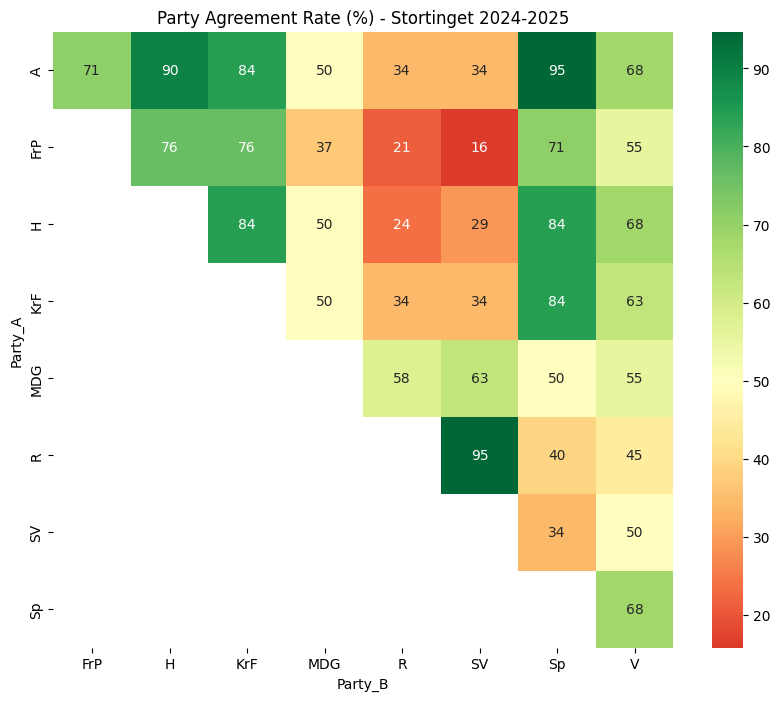

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data to create a matrix
matrix_df = df.pivot(index='Party_A', columns='Party_B', values='Agreement_Rate_%')

plt.figure(figsize=(10, 8))
sns.heatmap(matrix_df, annot=True, cmap="RdYlGn", center=50)
plt.title("Party Agreement Rate (%) - Stortinget 2024-2025")
plt.show()